# FAISS Retrieval Evaluation (CPU)

This notebook evaluates FAISS retrieval using pre-built indices.

**Can run on CPU** - indices are loaded from disk.

Evaluates:
- 3 embedding models (Legal-BERT, GTE-Large, BGE-Large)
- 2 fields (content, metadata)
- All 10 legal queries

Total: 6 retrieval configurations

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

from src.data_loader import load_data, prepare_data, get_documents_by_field
from src.queries import get_all_queries
from src.faiss_retriever import FAISSRetriever, evaluate_faiss
from src.evaluation import (
    print_query_results, 
    create_comparison_table,
    calculate_overlap,
    analyze_retrieval_diversity
)
from src.config import EMBEDDING_MODELS, INDICES_DIR, RESULTS_DIR, TOP_K

sns.set_style('whitegrid')
print("✓ Imports successful")

✓ Imports successful


## 1. Load and Prepare Data

In [2]:
# Load data
df = load_data()
df = prepare_data(df)

# Get queries
queries = get_all_queries()
print(f"Loaded {len(df)} documents and {len(queries)} queries")

Loading data from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\data\acts_with_metadata.tsv...
Loaded 7067 records
Creating metadata field...
Metadata field created
Loaded 7067 documents and 10 queries


## 2. Verify Indices Exist

In [3]:
# Check which indices are available
available_indices = []

print("Available FAISS Indices:")
print("="*80)

for model_key in EMBEDDING_MODELS.keys():
    for field in ['content', 'metadata']:
        index_dir = INDICES_DIR / f"{field}_{model_key}"
        index_file = index_dir / "index.faiss"
        
        if index_file.exists():
            available_indices.append((model_key, field))
            print(f"✓ {field}_{model_key}")
        else:
            print(f"✗ {field}_{model_key} - NOT FOUND")

print(f"\nTotal available: {len(available_indices)} / 6")

if len(available_indices) == 0:
    print("\n⚠️ ERROR: No indices found!")
    print("Please run notebook 03 (FAISS Index Builder) first.")

Available FAISS Indices:
✓ content_legal-bert
✓ metadata_legal-bert
✓ content_gte-large
✓ metadata_gte-large
✓ content_bge-large
✓ metadata_bge-large
✓ content_bge-m3
✓ metadata_bge-m3

Total available: 8 / 6


## 3. Run FAISS Retrieval for All Models

In [4]:
# Store all results
all_results = {}

for model_key in EMBEDDING_MODELS.keys():
    for field in ['content', 'metadata']:
        index_dir = INDICES_DIR / f"{field}_{model_key}"
        index_file = index_dir / "index.faiss"
        
        if not index_file.exists():
            print(f"Skipping {field}_{model_key} - index not found")
            continue
        
        print(f"\n{'='*80}")
        print(f"Evaluating: {model_key} on {field}")
        print(f"{'='*80}")
        
        # Evaluate
        results = evaluate_faiss(
            model_key=model_key,
            queries=queries,
            field_name=field,
            top_k=TOP_K
        )
        
        # Store results
        key = f"faiss_{model_key}_{field}"
        all_results[key] = results
        
        # Save individual results
        output_file = RESULTS_DIR / f"{key}_results.json"
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to: {output_file}")

print(f"\n✓ Completed {len(all_results)} evaluations")


Evaluating: legal-bert on content

FAISS EVALUATION - LEGAL-BERT - CONTENT

Loading model: nlpaueb/legal-bert-base-uncased
Library: sentence-transformers
Device: cpu


No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.


Loading index from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\indices\content_legal-bert\index.faiss...
Index loaded with 7067 vectors
Model: nlpaueb/legal-bert-base-uncased
Dimension: 768
Processing query 1/10: What are the procedures for presidential elections...
Processing query 2/10: What are the tax obligations and payment requireme...
Processing query 3/10: What are the penalty provisions for bribery and un...
Processing query 4/10: What is the process for filing appeals to the Boar...
Processing query 5/10: What are the voting procedures and ballot requirem...
Processing query 6/10: How are taxes assessed and collected, and what pow...
Processing query 7/10: What are the establishment provisions and governan...
Processing query 8/10: What are the import duty requirements and customs ...
Processing query 9/10: What is the nomination process and requirements fo...
Processing query 10/10: What are the powers and functions of the Commissio...

Results:
  Average retrieval time:

No sentence-transformers model found with name nlpaueb/legal-bert-base-uncased. Creating a new one with mean pooling.


Loading index from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\indices\metadata_legal-bert\index.faiss...
Index loaded with 7067 vectors
Model: nlpaueb/legal-bert-base-uncased
Dimension: 768
Processing query 1/10: What are the procedures for presidential elections...
Processing query 2/10: What are the tax obligations and payment requireme...
Processing query 3/10: What are the penalty provisions for bribery and un...
Processing query 4/10: What is the process for filing appeals to the Boar...
Processing query 5/10: What are the voting procedures and ballot requirem...
Processing query 6/10: How are taxes assessed and collected, and what pow...
Processing query 7/10: What are the establishment provisions and governan...
Processing query 8/10: What are the import duty requirements and customs ...
Processing query 9/10: What is the nomination process and requirements fo...
Processing query 10/10: What are the powers and functions of the Commissio...

Results:
  Average retrieval time

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading index from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\indices\content_bge-m3\index.faiss...
Index loaded with 7067 vectors
Model: BAAI/bge-m3
Dimension: 1024
Processing query 1/10: What are the procedures for presidential elections...


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 372.40it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Processing query 2/10: What are the tax obligations and payment requireme...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Processing query 3/10: What are the penalty provisions for bribery and un...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Processing query 4/10: What is the process for filing appeals to the Boar...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Processing query 5/10: What are the voting procedures and ballot requirem...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Processing query 6/10: How are taxes assessed and collected, and what pow...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Processing query 7/10: What are the establishment provisions and governan...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Processing query 8/10: What are the import duty requirements and customs ...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Processing query 9/10: What is the nomination process and requirements fo...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Processing query 10/10: What are the powers and functions of the Commissio...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]



Results:
  Average retrieval time: 0.8045 seconds
  Total queries: 10

Results saved to: d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\faiss_bge-m3_content_results.json

Evaluating: bge-m3 on metadata

FAISS EVALUATION - BGE-M3 - METADATA

Loading model: BAAI/bge-m3
Library: flagembedding
Device: cpu


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading index from d:\Core\_Code D\LegalAI-model-eval\notebooks\..\indices\metadata_bge-m3\index.faiss...
Index loaded with 7067 vectors
Model: BAAI/bge-m3
Dimension: 1024
Processing query 1/10: What are the procedures for presidential elections...


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1198.37it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Processing query 2/10: What are the tax obligations and payment requireme...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Processing query 3/10: What are the penalty provisions for bribery and un...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Processing query 4/10: What is the process for filing appeals to the Boar...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Processing query 5/10: What are the voting procedures and ballot requirem...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Processing query 6/10: How are taxes assessed and collected, and what pow...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Processing query 7/10: What are the establishment provisions and governan...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Processing query 8/10: What are the import duty requirements and customs ...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Processing query 9/10: What is the nomination process and requirements fo...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Processing query 10/10: What are the powers and functions of the Commissio...


Inference Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]



Results:
  Average retrieval time: 0.6932 seconds
  Total queries: 10

Results saved to: d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\faiss_bge-m3_metadata_results.json

✓ Completed 8 evaluations


## 4. Compare Models on Content Field

Content Field - Model Comparison:
     Model  Avg Time (s)                      Model Name
legal-bert      0.079832 nlpaueb/legal-bert-base-uncased
 gte-large      0.268327              thenlper/gte-large
 bge-large      0.473017          BAAI/bge-large-en-v1.5
    bge-m3      0.804516                     BAAI/bge-m3


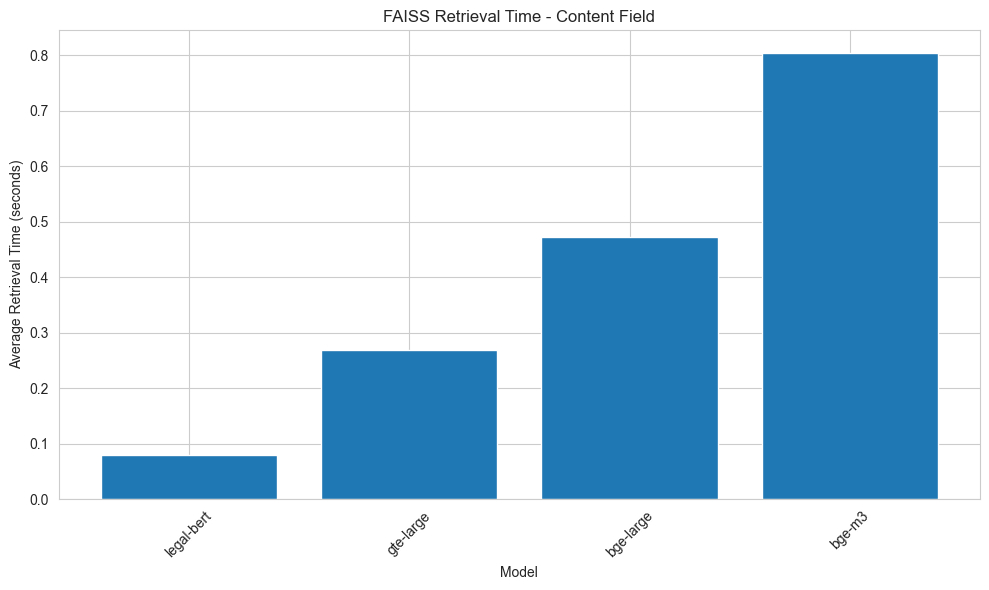

In [5]:
# Compare retrieval times for content field
content_results = {k: v for k, v in all_results.items() if 'content' in k}

if content_results:
    comparison_data = []
    
    for key, results in content_results.items():
        model = results['model']
        comparison_data.append({
            'Model': model,
            'Avg Time (s)': results['avg_retrieval_time'],
            'Model Name': results['model_name']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("Content Field - Model Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Model'], comparison_df['Avg Time (s)'])
    plt.xlabel('Model')
    plt.ylabel('Average Retrieval Time (seconds)')
    plt.title('FAISS Retrieval Time - Content Field')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 5. Compare Models on Metadata Field

Metadata Field - Model Comparison:
     Model  Avg Time (s)                      Model Name
legal-bert      0.073752 nlpaueb/legal-bert-base-uncased
 gte-large      0.299553              thenlper/gte-large
 bge-large      0.331123          BAAI/bge-large-en-v1.5
    bge-m3      0.693152                     BAAI/bge-m3


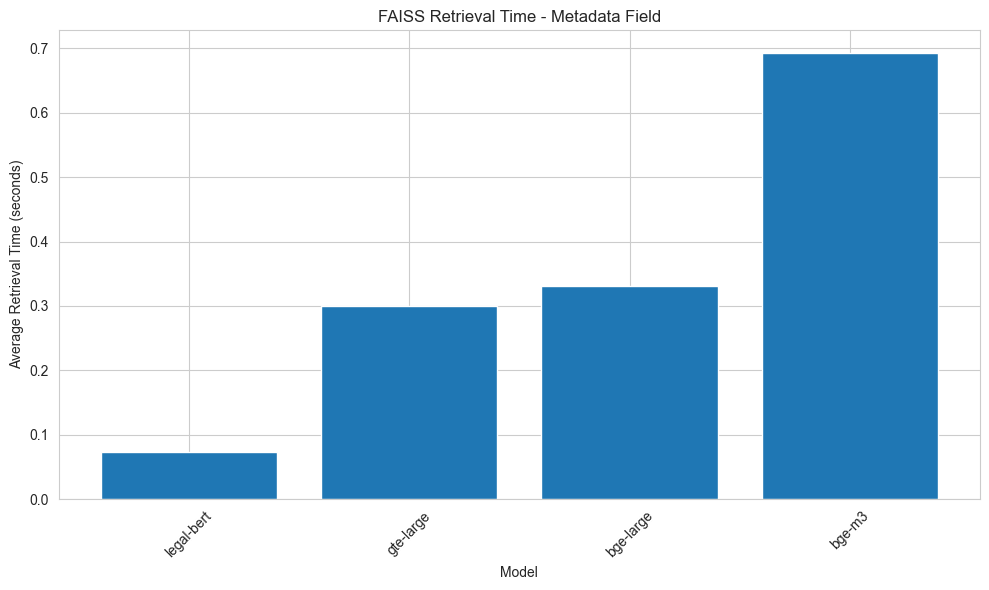

In [6]:
# Compare retrieval times for metadata field
metadata_results = {k: v for k, v in all_results.items() if 'metadata' in k}

if metadata_results:
    comparison_data = []
    
    for key, results in metadata_results.items():
        model = results['model']
        comparison_data.append({
            'Model': model,
            'Avg Time (s)': results['avg_retrieval_time'],
            'Model Name': results['model_name']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("Metadata Field - Model Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(comparison_df['Model'], comparison_df['Avg Time (s)'])
    plt.xlabel('Model')
    plt.ylabel('Average Retrieval Time (seconds)')
    plt.title('FAISS Retrieval Time - Metadata Field')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 6. Analyze Query-Specific Results

In [7]:
# Compare all models for a specific query
def compare_models_for_query(query_id, field='content'):
    """Compare all models for a specific query."""
    query = queries[query_id - 1]
    
    print(f"\n{'='*80}")
    print(f"QUERY {query_id}: {query['query']}")
    print(f"Field: {field}")
    print(f"{'='*80}\n")
    
    for model_key in EMBEDDING_MODELS.keys():
        key = f"faiss_{model_key}_{field}"
        if key in all_results:
            results = all_results[key]
            query_result = results['results'][query_id - 1]
            
            print(f"\n--- {model_key.upper()} ---")
            print_query_results(
                df=df,
                query=query['query'],
                indices=query_result['retrieved_indices'],
                scores=query_result['scores'],
                top_n=3,
                field=field
            )

# Example: Compare models for query 1 on content
compare_models_for_query(1, 'content')


QUERY 1: What are the procedures for presidential elections when the office becomes vacant?
Field: content


--- LEGAL-BERT ---

Query: What are the procedures for presidential elections when the office becomes vacant?

Rank 1 (Score: 0.8258):
  Key: 2016-6-07
  Title: Asian Infrastructure Investment Bank Agreement (Ratification)
  Content (first 200 chars): 44 Act, No. 7 of 2016
 (c)
The votes of all the Governors who cast votes for each
candidate shall be added in descending order of number,
until the number of votes representing the applicable
Adjustme...

Rank 2 (Score: 0.8217):
  Key: 1981-2-04
  Title: Consular Functions
  Content (first 200 chars): . Annual subscription of Bills and Laws of the Parliament Rs. 30 (Local), Rs. 40 (Foreign). payable to the SUPERINTENDENT, GOVERNMENT PUBLICATIONS BUREAU, P. O. Box 500, COLOMBO 1, before 15th Decembe...

Rank 3 (Score: 0.8122):
  Key: 2017-9-17
  Title: Provincial Councils Elections (Amendment)
  Content (first 200 chars): Act, No. 

In [8]:
# Compare overlap between models for a query
def analyze_model_overlap(query_id, field='content'):
    """Analyze overlap in results between different models."""
    query = queries[query_id - 1]
    
    print(f"\nQuery {query_id}: {query['query']}")
    print(f"Field: {field}\n")
    
    # Get results from all models
    model_results = {}
    for model_key in EMBEDDING_MODELS.keys():
        key = f"faiss_{model_key}_{field}"
        if key in all_results:
            query_result = all_results[key]['results'][query_id - 1]
            model_results[model_key] = query_result['retrieved_indices']
    
    # Calculate pairwise overlap
    models = list(model_results.keys())
    print("Pairwise Overlap (Jaccard Similarity):\n")
    
    for i, model1 in enumerate(models):
        for model2 in models[i+1:]:
            overlap = calculate_overlap(model_results[model1], model_results[model2])
            print(f"{model1} vs {model2}: {overlap:.2%}")

# Example analysis
analyze_model_overlap(1, 'content')


Query 1: What are the procedures for presidential elections when the office becomes vacant?
Field: content

Pairwise Overlap (Jaccard Similarity):

legal-bert vs gte-large: 5.26%
legal-bert vs bge-large: 11.11%
legal-bert vs bge-m3: 0.00%
gte-large vs bge-large: 53.85%
gte-large vs bge-m3: 42.86%
bge-large vs bge-m3: 33.33%


## 7. Overall Performance Comparison

In [9]:
# Create comprehensive comparison table
comparison_table = create_comparison_table(all_results)

print("\nFAISS Retrieval Performance Summary:")
print("="*80)
print(comparison_table.to_string(index=False))

# Save comparison
comparison_table.to_csv(RESULTS_DIR / "faiss_comparison.csv", index=False)
print(f"\nComparison table saved to: {RESULTS_DIR / 'faiss_comparison.csv'}")


FAISS Retrieval Performance Summary:
                   Method    Field  Avg Retrieval Time (s)  Num Queries Num Documents      Model
 faiss_legal-bert_content  content                0.079832           10           N/A legal-bert
faiss_legal-bert_metadata metadata                0.073752           10           N/A legal-bert
  faiss_gte-large_content  content                0.268327           10           N/A  gte-large
 faiss_gte-large_metadata metadata                0.299553           10           N/A  gte-large
  faiss_bge-large_content  content                0.473017           10           N/A  bge-large
 faiss_bge-large_metadata metadata                0.331123           10           N/A  bge-large
     faiss_bge-m3_content  content                0.804516           10           N/A     bge-m3
    faiss_bge-m3_metadata metadata                0.693152           10           N/A     bge-m3

Comparison table saved to: d:\Core\_Code D\LegalAI-model-eval\notebooks\..\results\faiss

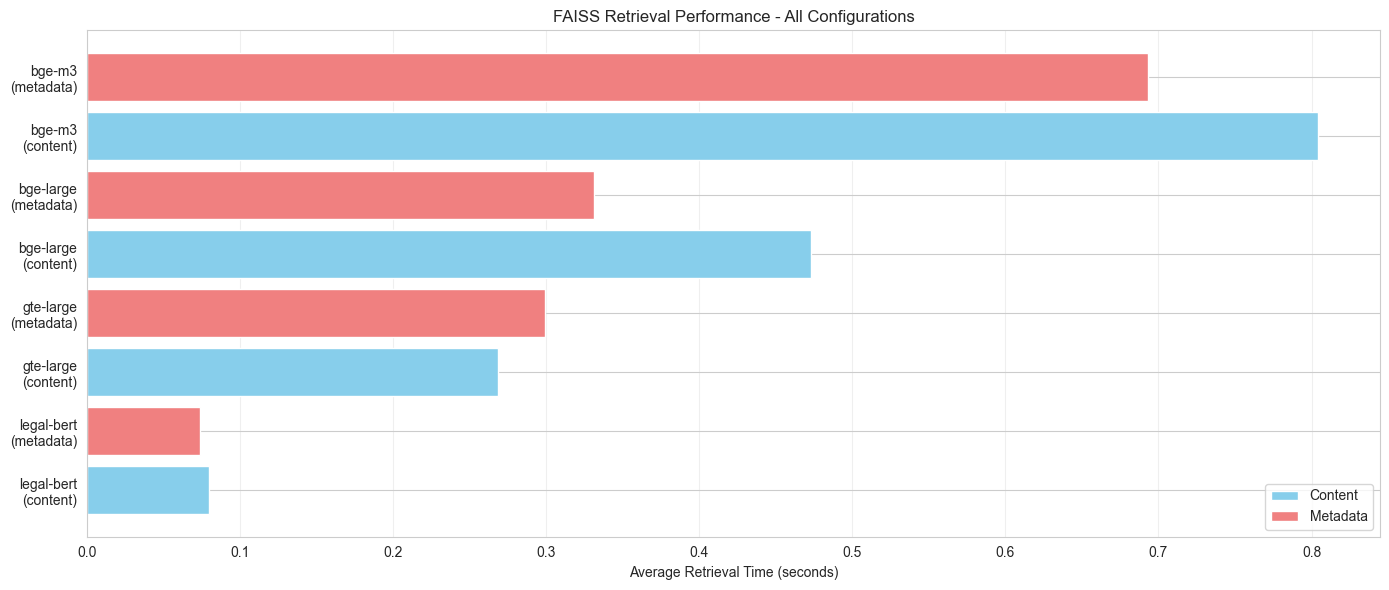

In [10]:
# Visualize all retrieval times
if len(all_results) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    methods = []
    times = []
    colors = []
    
    for key, results in all_results.items():
        label = f"{results['model']}\n({results['field']})"
        methods.append(label)
        times.append(results['avg_retrieval_time'])
        colors.append('skyblue' if results['field'] == 'content' else 'lightcoral')
    
    ax.barh(methods, times, color=colors)
    ax.set_xlabel('Average Retrieval Time (seconds)')
    ax.set_title('FAISS Retrieval Performance - All Configurations')
    ax.grid(axis='x', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', label='Content'),
        Patch(facecolor='lightcoral', label='Metadata')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

## 8. Retrieval Diversity Analysis

In [11]:
# Analyze diversity of retrieved documents
from src.evaluation import analyze_retrieval_diversity, print_diversity_analysis

print("Retrieval Diversity Analysis:")
print("="*80)

for key, results in all_results.items():
    print(f"\n{key}:")
    diversity = analyze_retrieval_diversity(results, df)
    print_diversity_analysis(diversity)

Retrieval Diversity Analysis:

faiss_legal-bert_content:

Diversity Analysis:
  Total unique documents retrieved: 63
  Total unique acts retrieved: 44
  Number of queries: 10
  Avg unique docs per query: 6.30

faiss_legal-bert_metadata:

Diversity Analysis:
  Total unique documents retrieved: 84
  Total unique acts retrieved: 45
  Number of queries: 10
  Avg unique docs per query: 8.40

faiss_gte-large_content:

Diversity Analysis:
  Total unique documents retrieved: 96
  Total unique acts retrieved: 40
  Number of queries: 10
  Avg unique docs per query: 9.60

faiss_gte-large_metadata:

Diversity Analysis:
  Total unique documents retrieved: 96
  Total unique acts retrieved: 27
  Number of queries: 10
  Avg unique docs per query: 9.60

faiss_bge-large_content:

Diversity Analysis:
  Total unique documents retrieved: 95
  Total unique acts retrieved: 43
  Number of queries: 10
  Avg unique docs per query: 9.50

faiss_bge-large_metadata:

Diversity Analysis:
  Total unique documents ret

## Summary

FAISS retrieval evaluation complete!

Key findings:
- Tested 3 embedding models (Legal-BERT, GTE-Large, BGE-Large)
- Evaluated on both content and metadata fields
- All results saved for further analysis and comparison
- Retrieval times measured on CPU

Model characteristics:
- **Legal-BERT**: Domain-specific, may excel on legal terminology
- **GTE-Large**: General-purpose SOTA, strong cross-domain performance  
- **BGE-Large**: Top retrieval model, excellent for ranking tasks

Next steps:
- Compare with BM25 results (notebook 02)
- Apply reranking to improve results (notebook 05)
- Analyze which model works best for different query types